In [1]:
! pip install sklearn-pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions
# change pycox import datasets and df= read.csv

df_train=pd.read_csv('D:/UNOS_NEW/waitt_dephit_train_cindex7.csv', sep=',')
df_test=pd.read_csv('D:/UNOS_NEW/waitt_dephit_test_cindex7.csv', sep=',')
df_val=pd.read_csv('D:/UNOS_NEW/waitt_dephit_val_cindex7.csv', sep=',')
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas
np.random.seed(1234)
_ = torch.manual_seed(123)

df_train['INIT_AGE']=df_train['INIT_AGE'].astype('float32')
df_train['INIT_BILIRUBIN']=df_train['INIT_BILIRUBIN'].astype('float32')
df_train['INIT_INR']=df_train['INIT_INR'].astype('float32')
df_train['INIT_SERUM_CREAT']=df_train['INIT_SERUM_CREAT'].astype('float32')
df_train['FUNC_STAT_TCR']=df_train['FUNC_STAT_TCR'].astype('float32')
df_train['INIT_ALBUMIN']=df_train['INIT_ALBUMIN'].astype('float32')
df_train['INIT_ASCITES']=df_train['INIT_ASCITES'].astype('float32')
df_train['LIFE_SUP_TCR']=df_train['LIFE_SUP_TCR'].astype('float32')
df_train['INIT_ENCEPH']=df_train['INIT_ENCEPH'].astype('float32')
df_train['VENTILATOR_TCR']=df_train['VENTILATOR_TCR'].astype('float32')
df_train['duration']=df_train['duration'].astype('float32')
df_train['event']=df_train['event'].astype('int32')

df_test['INIT_AGE']=df_test['INIT_AGE'].astype('float32')
df_test['INIT_BILIRUBIN']=df_test['INIT_BILIRUBIN'].astype('float32')
df_test['INIT_INR']=df_test['INIT_INR'].astype('float32')
df_test['INIT_SERUM_CREAT']=df_test['INIT_SERUM_CREAT'].astype('float32')
df_test['FUNC_STAT_TCR']=df_test['FUNC_STAT_TCR'].astype('float32')
df_test['INIT_ALBUMIN']=df_test['INIT_ALBUMIN'].astype('float32')
df_test['INIT_ASCITES']=df_test['INIT_ASCITES'].astype('float32')
df_test['LIFE_SUP_TCR']=df_test['LIFE_SUP_TCR'].astype('float32')
df_test['INIT_ENCEPH']=df_test['INIT_ENCEPH'].astype('float32')
df_test['VENTILATOR_TCR']=df_test['VENTILATOR_TCR'].astype('float32')
df_test['duration']=df_test['duration'].astype('float32')
df_test['event']=df_test['event'].astype('int32')

df_val['INIT_AGE']=df_val['INIT_AGE'].astype('float32')
df_val['INIT_BILIRUBIN']=df_val['INIT_BILIRUBIN'].astype('float32')
df_val['INIT_INR']=df_val['INIT_INR'].astype('float32')
df_val['INIT_SERUM_CREAT']=df_val['INIT_SERUM_CREAT'].astype('float32')
df_val['FUNC_STAT_TCR']=df_val['FUNC_STAT_TCR'].astype('float32')
df_val['INIT_ALBUMIN']=df_val['INIT_ALBUMIN'].astype('float32')
df_val['INIT_ASCITES']=df_val['INIT_ASCITES'].astype('float32')
df_val['LIFE_SUP_TCR']=df_val['LIFE_SUP_TCR'].astype('float32')
df_val['INIT_ENCEPH']=df_val['INIT_ENCEPH'].astype('float32')
df_val['VENTILATOR_TCR']=df_val['VENTILATOR_TCR'].astype('float32')
df_val['duration']=df_val['duration'].astype('float32')
df_val['event']=df_val['event'].astype('int32')

In [2]:
import numpy as np
import pandas as pd

class OrderedCategoricalLong:
    """Transform pandas series or numpy array to categorical, and get (long) values,
    i.e. index of category. Useful for entity embeddings.
    Zero is reserved for unknown categories or nans.
    Keyword Arguments:
        min_per_category {int} -- Number of instances required to not be set to nan (default: {20})
        return_series {bool} -- If return a array or pd.Series (default: {False})
    
    Returns:
        [pd.Series] -- Series with long values reffering to categories.
    """
    def __init__(self, min_per_category=20, return_series=False):
        
        self.min_per_category = min_per_category
        self.return_series = return_series

    def fit(self, series, y=None):
        series = pd.Series(series).copy()
        smaller = series.value_counts() < self.min_per_category
        values = smaller[smaller].index.values
        for v in values:
            series[series == v] = np.nan
        self.categories = series.astype('category').cat.categories
        return self
    
    def transform(self, series, y=None):
        series = pd.Series(series).copy()
        transformed = pd.Categorical(series, categories=self.categories, ordered=True)
        transformed = pd.Series(transformed, index=series.index)
        transformed = transformed.cat.codes.astype('int64') + 1
        return transformed if self.return_series else transformed.values
    
    def fit_transform(self, series, y=None):
        return self.fit(series, y).transform(series, y)
cols_std = ['INIT_AGE','INIT_ALBUMIN', 'INIT_BILIRUBIN', 'INIT_INR', 'INIT_SERUM_CREAT'] # numeric variables
cols_bin = ['LIFE_SUP_TCR','VENTILATOR_TCR'] # binary variables
cols_cat = ['FUNC_STAT_TCR','INIT_ASCITES','INIT_ENCEPH'] # categorical variables

standardize = [([col], StandardScaler()) for col in cols_std]
leave = [(col, None) for col in cols_bin]
categorical = [(col, OrderedCategoricalLong()) for col in cols_cat]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to convert data to 'int64'

x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

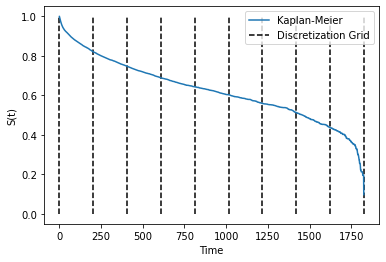

In [3]:
num_durations = 10
scheme = 'equidistant' # or quantiles
labtrans = DeepHitSingle.label_transform(num_durations, scheme)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

# Plotting discrete intervals
from pycox.utils import kaplan_meier
plt.vlines(labtrans.cuts, 0, 1, colors='black', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

In [4]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [64, 64]
batch_norm = True
dropout = 0.3

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)
                                 
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)

model = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts)

In [5]:
batch_size = 700
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=50)
lrfind.get_best_lr()

C:\Users\xiaoz\anaconda3\lib\site-packages\torchtuples\callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  p.data = p.data.add(-weight_decay * eta, p.data)


0.08902150854450441

In [6]:
model.optimizer.set_lr(0.089)

In [7]:
epochs = 100
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True 

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 0.8501,	val_loss: 0.4366
1:	[0s / 0s],		train_loss: 0.6396,	val_loss: 0.7067
2:	[0s / 0s],		train_loss: 0.5222,	val_loss: 0.4361
3:	[0s / 0s],		train_loss: 0.4239,	val_loss: 0.3458
4:	[0s / 0s],		train_loss: 0.3589,	val_loss: 0.2957
5:	[0s / 0s],		train_loss: 0.3971,	val_loss: 0.3094
6:	[0s / 1s],		train_loss: 0.3325,	val_loss: 0.3070
7:	[0s / 1s],		train_loss: 0.3206,	val_loss: 0.2869
8:	[0s / 1s],		train_loss: 0.3107,	val_loss: 0.2652
9:	[0s / 1s],		train_loss: 0.2890,	val_loss: 0.2673
10:	[0s / 1s],		train_loss: 0.2701,	val_loss: 0.2517
11:	[0s / 1s],		train_loss: 0.2635,	val_loss: 0.2575
12:	[0s / 2s],		train_loss: 0.2564,	val_loss: 0.2486
13:	[0s / 2s],		train_loss: 0.2549,	val_loss: 0.2480
14:	[0s / 2s],		train_loss: 0.2546,	val_loss: 0.2477
15:	[0s / 2s],		train_loss: 0.3008,	val_loss: 0.3104
16:	[0s / 2s],		train_loss: 0.2943,	val_loss: 0.2622
17:	[0s / 2s],		train_loss: 0.2565,	val_loss: 0.2463
18:	[0s / 2s],		train_loss: 0.2445,	val_loss: 0.2523
19:

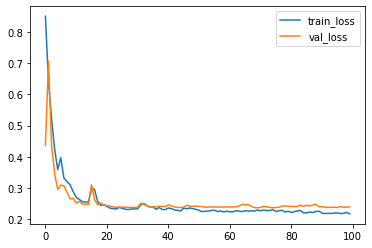

In [11]:
_ = log.plot()

In [12]:
surv = model.predict_surv_df(x_test)

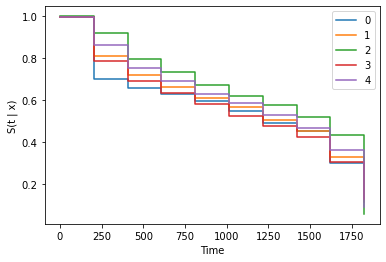

In [13]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [14]:
surv = model.interpolate(10).predict_surv_df(x_test)

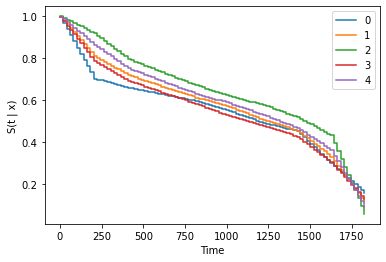

In [15]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [16]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [17]:
ev.concordance_td('antolini')

0.764066532012685

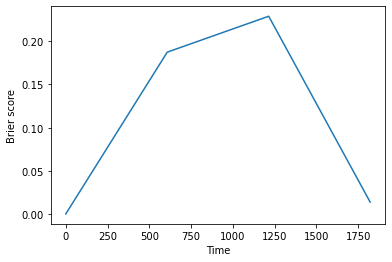

In [18]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 4)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

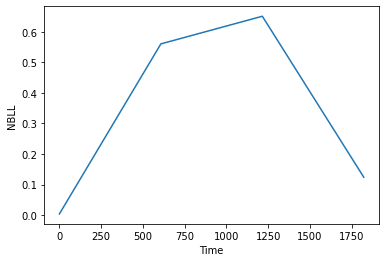

In [19]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [20]:
ev.integrated_brier_score(time_grid) 

0.1522553068269334

In [21]:
ev.integrated_nbll(time_grid) 

0.45528172058625155

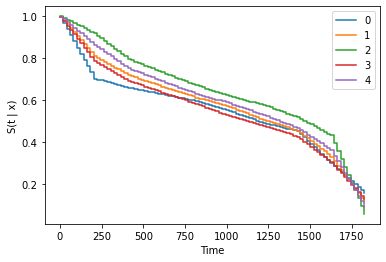

In [22]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

TypeError: unsupported operand type(s) for -: 'str' and 'float'

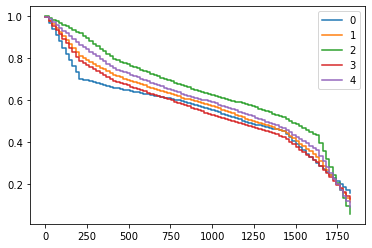

In [56]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)'-0.2)
_ = plt.xlabel('Time')

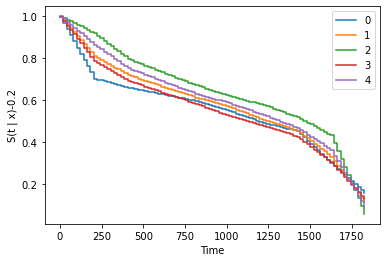

In [57]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)-0.2')
_ = plt.xlabel('Time')

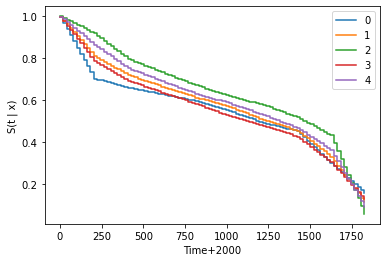

In [58]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time+2000')

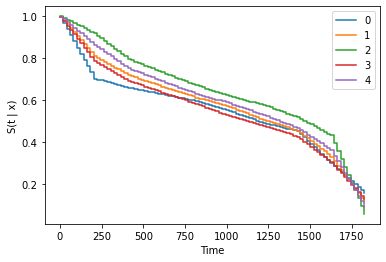

In [59]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

<AxesSubplot:>

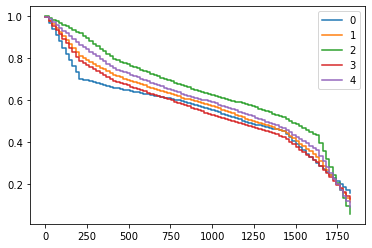

In [60]:
surv.iloc[:, :5].plot(drawstyle='steps-post')


In [3]:
surv = model.predict_surv_df(x_test)

NameError: name 'model' is not defined

In [23]:
surv.head()

,0,1,2,3,4,5,6,7,8,9,...,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099
0.000000,0.997579,0.998035,0.999563,0.996945,0.998223,0.997653,0.997600,0.997220,0.997604,0.998204,...,0.997732,0.998275,0.997619,0.999228,0.997663,0.997608,0.998219,0.997458,0.997908,0.999074
20.277777,0.967984,0.979105,0.991418,0.975871,0.984753,0.971656,0.970221,0.974295,0.960352,0.983266,...,0.974553,0.984179,0.969249,0.988260,0.972468,0.958164,0.986280,0.967256,0.983077,0.990068
40.555554,0.938388,0.960176,0.983273,0.954798,0.971283,0.945659,0.942842,0.951369,0.923100,0.968327,...,0.951374,0.970083,0.940879,0.977293,0.947273,0.918719,0.974342,0.937054,0.968246,0.981062
60.833331,0.908793,0.941246,0.975128,0.933724,0.957813,0.919661,0.915463,0.928444,0.885848,0.953389,...,0.928195,0.955987,0.912508,0.966325,0.922079,0.879274,0.962403,0.906852,0.953415,0.972056
81.111108,0.879197,0.922317,0.966983,0.912651,0.944343,0.893664,0.888084,0.905518,0.848597,0.938451,...,0.905016,0.941891,0.884138,0.955358,0.896884,0.839830,0.950464,0.876650,0.938584,0.963050


In [36]:
print(surv)

                 0         1         2         3         4         5     \
0.000000     0.998383  0.997845  0.998012  0.998593  0.999042  0.998661   
68.922223    0.964116  0.955697  0.958159  0.967436  0.970000  0.968325   
137.844446   0.929848  0.913550  0.918305  0.936279  0.940958  0.937990   
206.766669   0.895580  0.871402  0.878451  0.905122  0.911916  0.907654   
275.688892   0.861312  0.829255  0.838598  0.873964  0.882874  0.877318   
...               ...       ...       ...       ...       ...       ...   
5927.311133  0.116445  0.113378  0.114649  0.124454  0.122608  0.126353   
5996.233350  0.107273  0.105993  0.106723  0.114007  0.111457  0.115461   
6065.155566  0.098101  0.098609  0.098796  0.103559  0.100305  0.104569   
6134.077783  0.088929  0.091224  0.090869  0.093112  0.089154  0.093676   
6203.000000  0.079758  0.083840  0.082943  0.082664  0.078003  0.082784   

                 6         7         8         9     ...      2090      2091  \
0.000000     0.9987